In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from scipy.stats import uniform, randint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, f1_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

Reading the data

In [2]:
df=pd.read_csv("Group_4_data_cleaned.csv",index_col=0)
df.head()

,height,length,area,eccen,p_black,p_and,mean_tr,blackpix,blackand,wb_trans,y
0,5.0,7,35,1.400,0.400,0.657,2.33,14,23.0,6.0,1
1,6.0,7,42,1.167,0.429,0.881,3.60,18,37.0,5.0,1
2,6.0,18,108,3.000,0.287,0.741,4.43,31,80.0,7.0,1
3,5.0,7,35,1.400,0.371,0.743,4.33,13,26.0,3.0,1
4,6.0,3,18,0.500,0.500,0.944,2.25,9,17.0,4.0,1


In [3]:
print(df.describe())
print(df.info())

            height       length         area        eccen      p_black  \
count  5473.000000  5473.000000  5473.000000  5473.000000  5473.000000   
mean      8.491778    75.944089   678.280833     9.422260     0.355031   
std       2.958167    77.844052   760.273682     9.661801     0.139284   
min       2.500000     1.000000     7.000000     0.007000     0.052000   
25%       7.000000    17.000000   114.000000     2.143000     0.261000   
50%       8.000000    41.000000   322.000000     5.167000     0.337000   
75%      10.000000   107.000000   980.000000    13.625000     0.426000   
max      14.500000   242.000000  2279.000000    30.848000     0.673500   

             p_and      mean_tr     blackpix     blackand     wb_trans  \
count  5473.000000  5473.000000  5473.000000  5473.000000  5473.000000   
mean      0.786324     2.578667   198.322310   492.037365    86.901242   
std       0.166482     1.310313   208.242346   532.593288    92.165275   
min       0.307000     1.000000     7

In [4]:
output_dict={1:'text',2:'horizontal line',3:'picture',4:'vertical line',5:'graphic'}
df["y"].value_counts().rename(index=output_dict)

text               4913
horizontal line     329
graphic             115
vertical line        88
picture              28
Name: y, dtype: int64

Here we can observe that the 'text' type is more compared with other classes which needs to be classified. If we predcit all the classes as text we get an accuracy of 89.7% for the above dataset.

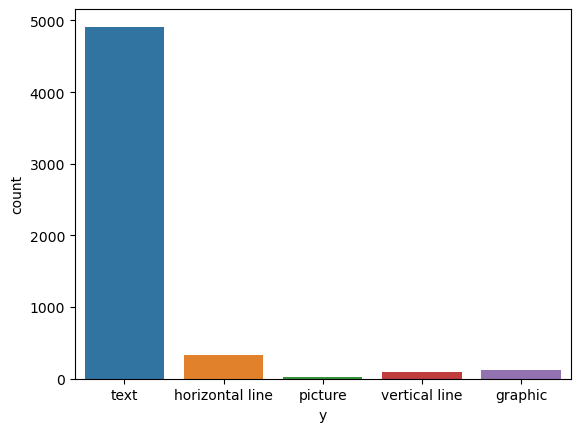

In [5]:
ax=sns.countplot(df['y'])
ax.set(xticklabels=output_dict.values())
plt.show()

## Model Building

In [6]:
X=df.iloc[:, :-1]
y=df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Diving the dataset to train and test with 80 an 20 percent ratio

In [7]:
# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We are scaling the features for the input dataframe using MinMaxScaler

In [8]:
y_train.value_counts()

1    3934
2     255
5      98
4      69
3      22
Name: y, dtype: int64

Here we can observe there a class imbalance. This can hamper our model accuracy big time. To deal with this problem we can either do oversampling or undersampling. If we do undersampling our train data will be reduced to 90 rows. Which will be very less for model building. Hence we choose oversampling the data.

In [9]:
oversampler = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train_scaled, y_train)

In [10]:
y_train_oversampled.value_counts()

1    3934
2    3934
5    3934
3    3934
4    3934
Name: y, dtype: int64

Now we can observe that all classes have same number of rows. This is done using RandomOverSampler from the imblearn library.

## We have choosed Support Vector Machines for our model

In [11]:
svm = SVC()


params= {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']
             } 

In [12]:
random_search = RandomizedSearchCV(svm, 
                            params,
                            cv = 5,
                            n_jobs=-1,
                            refit = True, 
                            verbose = 3)
random_search.fit(X_train_oversampled, y_train_oversampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']},
                   verbose=3)

In [13]:
print(f"The best hyperparameters: {random_search.best_params_}")
print(f"The best score: {random_search.best_score_}")

The best hyperparameters: {'kernel': 'rbf', 'gamma': 0.1, 'C': 1000}
The best score: 0.9803762074224707


Performing RandomizedSearchCV on the train data which gives the best n value, max_features and the max_depth.

In [14]:
print(random_search.best_estimator_)

SVC(C=1000, gamma=0.1)


In [15]:
SVM = SVC(kernel=random_search.best_params_['kernel'], C=random_search.best_params_['C'], gamma=random_search.best_params_['gamma'])
SVM.fit(X_train_oversampled, y_train_oversampled)

SVC(C=1000, gamma=0.1)

In [16]:
y_pred=SVM.predict(X_test_scaled)

In [17]:
accuracy_score(y_test,y_pred)

0.9378995433789954

## Model Evaluation

In [18]:
cv_scores = cross_val_score(SVM, 
                            X_train_oversampled, 
                            y_train_oversampled, 
                            cv=KFold(n_splits=10, shuffle=True),
                            scoring='accuracy')

cv_scores

array([0.98118963, 0.98474835, 0.98271479, 0.97305541, 0.97763091,
       0.98373157, 0.98169802, 0.97915608, 0.97508897, 0.98525674])

Average Accuracy 0.9804270462633452
Standard deviation of Accuracy 0.003906659777008264


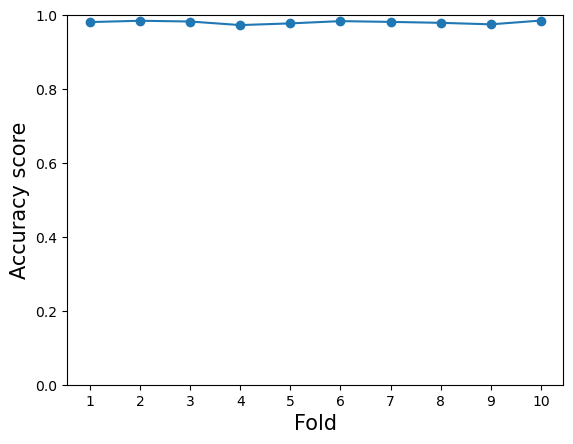

In [19]:
plt.plot(range(1, 11), cv_scores, marker='o')
plt.ylim(0, 1)
plt.ylabel('Accuracy score', fontsize=15)
plt.xlabel('Fold', fontsize=15)
plt.xticks(range(1,11))
print("Average Accuracy",cv_scores.mean())
print("Standard deviation of Accuracy",cv_scores.std())

## Confusion Matrix

In [20]:
cm=confusion_matrix(y_test, y_pred)
cm

array([[924,  13,   2,  10,  30],
       [  1,  71,   0,   2,   0],
       [  2,   0,   4,   0,   0],
       [  2,   0,   0,  17,   0],
       [  4,   2,   0,   0,  11]])

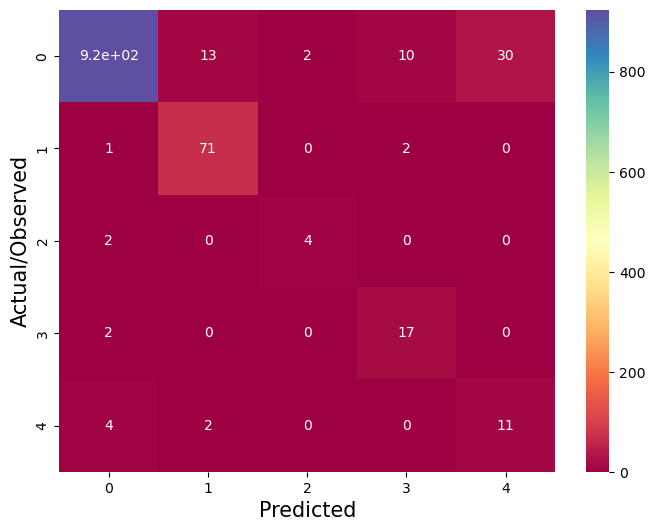

In [21]:
plt.figure(figsize = (8,6))

sns.heatmap(cm, 
            annot=True, 
            cmap="Spectral")
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual/Observed', fontsize=15);

## Classification report

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.94      0.97       979
           2       0.83      0.96      0.89        74
           3       0.67      0.67      0.67         6
           4       0.59      0.89      0.71        19
           5       0.27      0.65      0.38        17

    accuracy                           0.94      1095
   macro avg       0.67      0.82      0.72      1095
weighted avg       0.96      0.94      0.95      1095

